In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 2)
import time
import random
import tensorflow as tf
print("Tensor Flow version {}".format(tf.__version__))

/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc", line #513
  (fname, cnt))


Tensor Flow version 1.0.0


# Yet Another RNN Tutorial

## Decoder

In the previous [tutorial](https://github.com/vlievin/Tensorflow-tutorials/blob/master/Yet%20Another%20RNN%20Tutorial%20-%20Part%201%20-%20encoder.ipynb), we have shown the ability of RNNs to be used as encode information. We had a neural network encoding a sequence of observations into a fixed length vector. Then this vector was used to predict one point. 

In this tutorial, we would like to predict a full sequence of points from the encoded representation of the input sequence.

## Generating Data

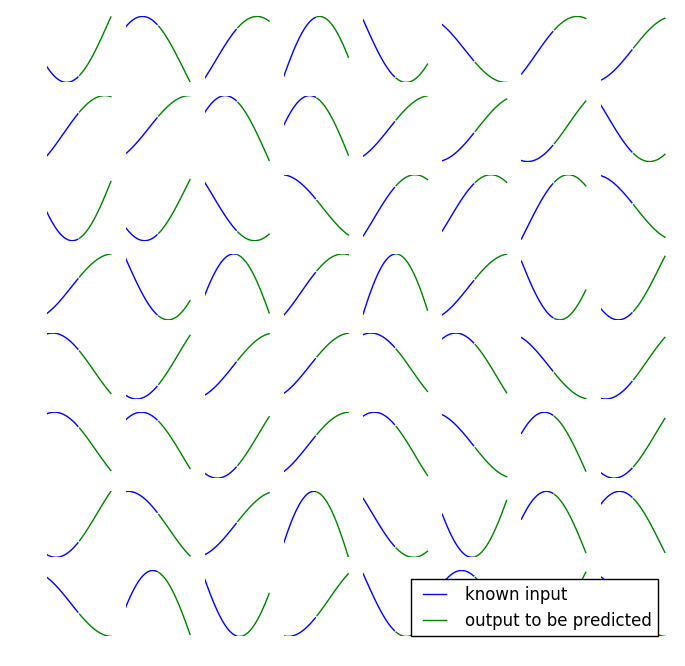

In [16]:
def get_samples(n_samples, phase):
    T = 100
    return [  [ 0.5 + 0.4 * np.sin( float(x) * 2 * np.pi / 100.0 + 2 * np.pi * phase )] for x in xrange(n_samples) ]

signal_size = 20

def get_batch(batch_len):
    xs = []
    ys = []
    for _ in xrange(batch_len):
        phase = random.random()
        samples = get_samples(signal_size+signal_size, phase)
        xs.append(samples[:signal_size])
        ys.append(samples[signal_size:])
    return xs,ys

n = 8
fig = plt.figure()
fig.set_figheight(n)
fig.set_figwidth(n)

batch_xs, batch_ys = get_batch(n**2)
fig_i=1
for xs, ys in zip(batch_xs, batch_ys):
    ax1 = fig.add_subplot(n,n,fig_i)
    ax1.plot(range(len(xs)),xs,color='blue')
    ax1.plot( [ len(xs) + u for u in range(len(ys))], ys, color='green')
    ax1.axis('off')
    fig_i += 1
    
    
# legend
handles, labels = ax1.get_legend_handles_labels()
display = (0,1,1)
# custom legend to plot
input_data = plt.Line2D((0,1),(0,0),color='blue')
label_data = plt.Line2D((0,1),(0,0), color='green')
#Create legend
ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[input_data,label_data],
          [label for i,label in enumerate(labels) if i in display]+['known input', 'output to be predicted'])

plt.show()

# The model

In [91]:
tf.reset_default_graph()

batch_size = 64
state_size = 8
data_dim = 1
dtype = tf.float32
learning_rate = 0.005
epoches = 200

previous_steps = tf.placeholder(dtype, [batch_size, signal_size, data_dim] , name='previous_steps_placeholder')
next_steps = tf.placeholder(dtype, [batch_size, signal_size, data_dim], name='next_step_placeholder')

## Encoder

In [92]:
def encoder(inputs):
    W = tf.Variable(tf.random_uniform([data_dim + state_size, state_size], 0, 1), dtype=dtype)
    b = tf.Variable(tf.zeros( [state_size] ), dtype=dtype)
    # initial memory
    initial_memory = tf.zeros([batch_size, state_size], dtype=dtype)
    memory = initial_memory
    rnn_inputs = tf.unstack(inputs, signal_size, axis=1)
    for x in rnn_inputs:
        # group inputs (previous memory s_t-1 + current input x_t)
        cell_inputs = tf.concat( [memory, x], 1) 
        # applying the cell
        memory = tf.nn.tanh( tf.add( tf.matmul( cell_inputs , W), b ) )
    return memory

inputs_encoding = encoder(previous_steps)

## Decoder

The Decoder RNN uses the encoding vector of the input as initial state: this is the knowledge about the input sequence. At each timestep, the hidden state cannot be used directly as output because the dimension of the hidden state doesn't necessarily match the dimension of the data. Therefore we use a linear layer as a projection from the hidden state space to the data space. 

<img width="700px" src="images/RNN_decoding.png"\>

In [93]:
W_proj = tf.Variable(tf.random_uniform([ state_size, data_dim], 0, 1), dtype=dtype)
b_proj = tf.Variable(tf.zeros( [data_dim] ), dtype=dtype)
    
def decoder(inputs_encoding):
    W = tf.Variable(tf.random_uniform([state_size, state_size], 0, 1), dtype=dtype)
    b = tf.Variable(tf.zeros( [state_size] ), dtype=dtype)
    hidden_state = inputs_encoding
    outputs = []
    for _ in range(signal_size):
        # update the hidden state
        hidden_state = tf.nn.tanh( tf.add( tf.matmul( hidden_state , W), b ) )
        # project the output
        output = tf.add( tf.matmul( hidden_state , W_proj), b_proj )
        outputs.append(output)
    outputs = tf.stack(outputs,1) 
    return outputs
        
predicted_next_steps =  decoder(inputs_encoding)  

## Objective function: RMSE

In [94]:
RMSE =  tf.reduce_mean( tf.pow( next_steps - predicted_next_steps, 2) ) # RMSE^2
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    with tf.name_scope('train_step'):
        optimizer =  tf.train.AdamOptimizer(learning_rate).minimize(RMSE)

## Training the model

In [95]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
xx = []
costs = []
for step in range(10000):
    batch_xs, batch_ys = get_batch(batch_size)
    batch_ys = [y for y in batch_ys]
    _,cost= sess.run([optimizer, RMSE], 
                                    feed_dict={previous_steps: batch_xs, next_steps: batch_ys})        
    xx.append(step)
    costs.append(cost)
    # Display logs per epoch step
    if step % 1000 == 0:
        print "step:", step, "| loss:" , cost

step: 0 | loss: 7.32807
step: 1000 | loss: 0.000242934
step: 2000 | loss: 0.000101144
step: 3000 | loss: 2.26572e-05
step: 4000 | loss: 6.16197e-05
step: 5000 | loss: 1.99509e-05
step: 6000 | loss: 4.64528e-05
step: 7000 | loss: 1.97067e-05
step: 8000 | loss: 7.73593e-06
step: 9000 | loss: 8.15097e-06


## Plotting the results

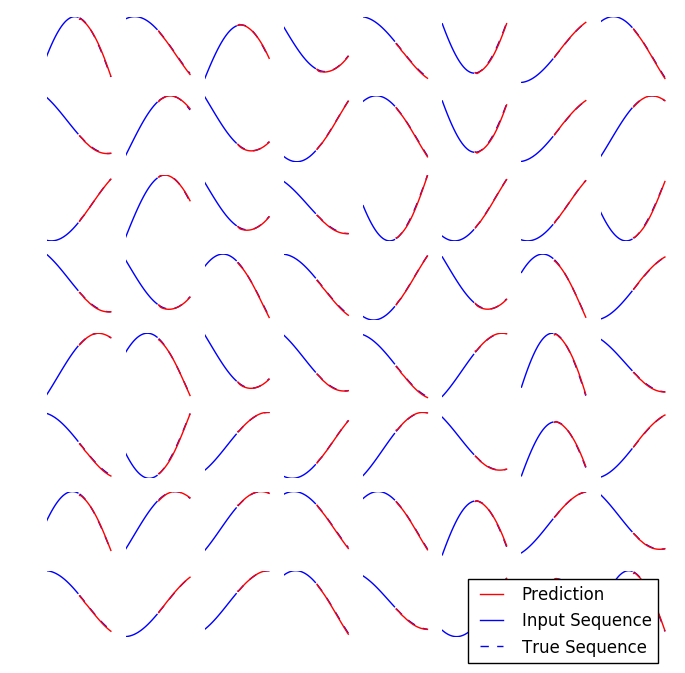

In [97]:
n = 8
fig = plt.figure()
fig.set_figheight(n)
fig.set_figwidth(n)

batch_xs, batch_ys = get_batch(n**2)
fig_i=1
for xs, ys in zip(batch_xs, batch_ys):
    dd = [ xs for x in xrange(batch_size)]
    pred= sess.run([predicted_next_steps], feed_dict={previous_steps: dd}) 
    ax1 = fig.add_subplot(n,n,fig_i)
    ax1.plot(range(len(xs)) ,xs ,color='blue')
    ax1 = fig.add_subplot(n,n,fig_i)
    ax1.plot([ len(xs) + u for u in range(len(ys))] ,ys , 'b--' )
    u = [ u[0] for u in pred[0][0]]
    ax1.plot([ len(xs) + uu for uu in range(len(ys))] ,u , color='red' )
    ax1.axis('off')
    fig_i += 1
    
    
# legend
handles, labels = ax1.get_legend_handles_labels()
display = (0,1,2)
# custom legend to plot
preds = plt.Line2D((0,1),(0,0), color='r')
input_data = plt.Line2D((0,1),(0,0),color='blue')
real_data = plt.Line2D((0,1),(0,0), color='blue', linestyle='--')
#Create legend
ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[preds,input_data,real_data],
          [label for i,label in enumerate(labels) if i in display]+['Prediction', 'Input Sequence', 'True Sequence'])

plt.show()